![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor

from xgboost import XGBRegressor

In [20]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [21]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [22]:
cat_cols = X.columns[X.columns.str.startswith('M_') == True]
for i in cat_cols:
    X[i] = X[i].astype('category').cat.codes

In [23]:
# Separación de datos en set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7031, 9) (3464, 9) (7031,) (3464,)


### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [24]:
# Celda 1
def mse_split(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    left_mse = np.mean((y_l - np.mean(y_l))**2)
    right_mse = np.mean((y_r - np.mean(y_r))**2)
    return (left_mse*len(y_l) + right_mse*len(y_r))/len(y)

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, mse
    
    # Para todas las varibles 
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
     
        for split in splits:
            mse = mse_split(X.iloc[:, j], y, split)
                        
            if mse > best_split[2]:
                best_split = [j, split, mse]
    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):

    # Calcular la mejor división
    j, split, mse = best_split(X, y, num_pct)

    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0],level=level, split=-1, n_samples=1, mse=mse)
        return tree
       
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    tree = dict(y_pred=y_pred,level=level, split=-1, n_samples=X.shape[0],mse=mse)

    # Revisar el criterio de parada 
    if mse < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    return tree

def tree_predict(X, tree):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
    return predicted

dt_model = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=5, num_pct=5)
y_pred_tree = tree_predict(X_test, dt_model)

print(f'Para Decision Tree Regressor (manual), el MAE es: {mean_absolute_error(y_test, y_pred_tree):,.3f}, y el RMSE es: {np.sqrt(mean_squared_error(y_test, y_pred_tree)):,.3f}.')

Para Decision Tree Regressor (manual), el MAE es: 2,089.021, y el RMSE es: 2,836.338.


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [25]:
# Celda 2
def bagging(X_train, y_train, X_test, B, seed):
    y_pred_test = np.zeros((X_test.shape[0], B))
    
    for i in range(B):
        np.random.seed(seed+i)
        idx = np.random.choice(range(X_train.shape[0]), size=X_train.shape[0], replace=True)
        reg = tree_grow(X_train.iloc[idx], y_train.iloc[idx], level=0, min_gain=0.001, max_depth=5, num_pct=5)
        y_pred_test[:, i] = tree_predict(X_test, reg)
    
    y_pred_test_mean = np.mean(y_pred_test, axis=1)
    
    return y_pred_test_mean

y_pred_test_mean = bagging(X_train, y_train, X_test, B=10, seed=42)

print(f'Para Bagging Regressor (manual), el MAE es: {mean_absolute_error(y_test, y_pred_test_mean):,.3f}, y el RMSE es: {np.sqrt(mean_squared_error(y_test, y_pred_test_mean)):,.3f}.') 

Para Bagging Regressor (manual), el MAE es: 1,903.467, y el RMSE es: 2,553.927.


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [26]:
# Celda 3

max_features_ = np.log(X_train.shape[1]).astype(int)

bag_reg = BaggingRegressor(n_estimators=10, random_state=0, max_features=max_features_)
bag_reg.fit(X_train, y_train)
y_pred = bag_reg.predict(X_test)

print(f'Para Bagging Regressor, el MAE es: {mean_absolute_error(y_test, y_pred):,.3f}, y el RMSE es: {np.sqrt(mean_squared_error(y_test, y_pred)):,.3f}.')

Para Bagging Regressor, el MAE es: 1,827.343, y el RMSE es: 2,354.449.


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [27]:
# Celda 4

rf_reg = RandomForestRegressor(random_state=0)
rf_reg.fit(X_train, y_train)
y_pred_ = rf_reg.predict(X_test)

print(f'Para Random Forest Regressor, el MAE es: {mean_absolute_error(y_test, y_pred_):,.3f}, y el RMSE es: {np.sqrt(mean_squared_error(y_test, y_pred_)):,.3f}.')

Para Random Forest Regressor, el MAE es: 1,310.185, y el RMSE es: 1,760.979.


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

La máxima profundidad óptima es: 8 (MAE:1,150.757).
El número óptimo de atributos es: 5 (MAE:1,140.474).
El número óptimo de estimadores es: 114 (MAE:1,139.597).
Para Random Forest Regressor (calibrado), el MAE es: 1,139.597, y el RMSE es: 1,553.818.


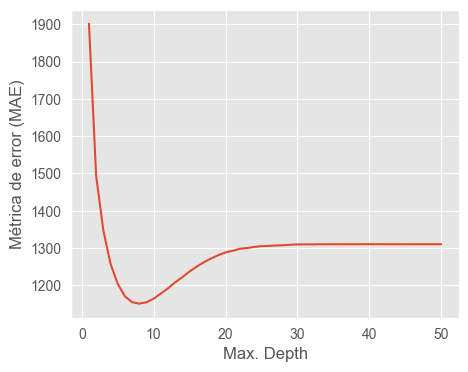

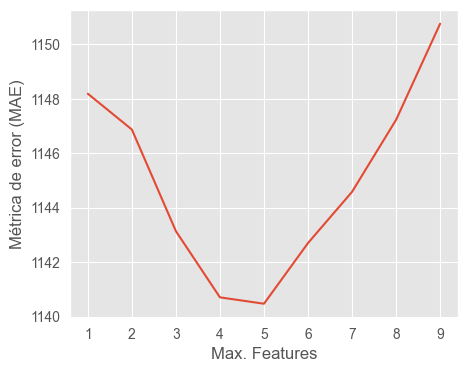

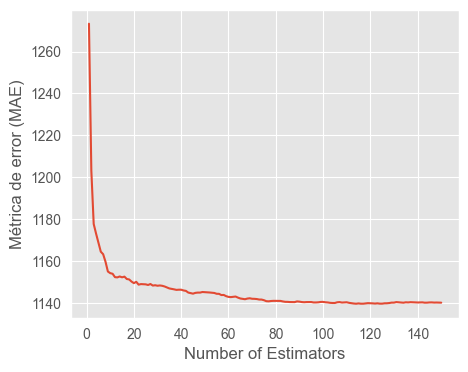

In [28]:
# Celda 5

# Calibración de hiperparámetros: Profundidad óptima del árbol (max_depth)
depth_range = range(1, 51)
mae_scores_depth= []

for depth in depth_range:
    rf_reg = RandomForestRegressor(random_state=0, max_depth=depth, n_jobs=-1)
    rf_reg.fit(X_train, y_train)
    y_pred_ = rf_reg.predict(X_test)
    mae_scores_depth.append(mean_absolute_error(y_test, y_pred_))

plt.figure(figsize=(5,4))
plt.plot(depth_range, mae_scores_depth)
plt.xlabel('Max. Depth')
plt.ylabel('Métrica de error (MAE)');

print(f'La máxima profundidad óptima es: {depth_range[np.argmin(mae_scores_depth)]} (MAE:{np.min(mae_scores_depth):,.3f}).')

# Calibración de hiperparámetros: Número óptimo de atributos del árbol (max_features)
max_features_range = range(1, X_train.shape[1]+1)
mae_scores_attr = [] 

for feature in max_features_range:
    rf_reg = RandomForestRegressor(random_state=0, max_features=feature, max_depth=depth_range[np.argmin(mae_scores_depth)], n_jobs=-1)
    rf_reg.fit(X_train, y_train)
    y_pred_ = rf_reg.predict(X_test)
    mae_scores_attr.append(mean_absolute_error(y_test, y_pred_)) 

plt.figure(figsize=(5,4))       
plt.plot(max_features_range, mae_scores_attr)
plt.xlabel('Max. Features')  
plt.ylabel('Métrica de error (MAE)');

print(f'El número óptimo de atributos es: {max_features_range[np.argmin(mae_scores_attr)]} (MAE:{np.min(mae_scores_attr):,.3f}).')

# Calibración de hiperparámetros: Número óptimo de estimadores (n_estimators)   

n_estimators_range = range(1, 151)
mae_scores_estim = []   

for estim in n_estimators_range:   
    rf_reg = RandomForestRegressor(n_estimators=estim, random_state=0, max_features=max_features_range[np.argmin(mae_scores_attr)], max_depth=depth_range[np.argmin(mae_scores_depth)], n_jobs=-1)
    rf_reg.fit(X_train, y_train)
    y_pred_ = rf_reg.predict(X_test)
    mae_scores_estim.append(mean_absolute_error(y_test, y_pred_))

plt.figure(figsize=(5,4))
plt.plot(n_estimators_range, mae_scores_estim)
plt.xlabel('Number of Estimators')
plt.ylabel('Métrica de error (MAE)');

print(f'El número óptimo de estimadores es: {n_estimators_range[np.argmin(mae_scores_estim)]} (MAE:{np.min(mae_scores_estim):,.3f}).')

#Modelo con hiperparámetros calibrados
rf_reg_opt = RandomForestRegressor(n_estimators=n_estimators_range[np.argmin(mae_scores_estim)], random_state=0, max_features=max_features_range[np.argmin(mae_scores_attr)], max_depth=depth_range[np.argmin(mae_scores_depth)], n_jobs=-1)
rf_reg_opt.fit(X_train, y_train)
y_pred_opt = rf_reg_opt.predict(X_test)

print(f'Para Random Forest Regressor (calibrado), el MAE es: {mean_absolute_error(y_test, y_pred_opt):,.3f}, y el RMSE es: {np.sqrt(mean_squared_error(y_test, y_pred_opt)):,.3f}.')

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [29]:
# Celda 6

xgb_reg = XGBRegressor(n_estimators=13, max_depth=5, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)

print(f'Para XGBoost Regressor, el MAE es: {mean_absolute_error(y_test, y_pred_xgb):,.3f}, y el RMSE es: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):,.3f}.')

Para XGBoost Regressor, el MAE es: 1,138.112, y el RMSE es: 1,551.929.


### Punto 7 - Calibración de parámetros XGBoost



En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

La rata de aprendizaje óptima es: 0.41 (MAE:1,134.575).
El valor de gamma óptimo es: 0.0 (MAE:1,134.575).
El número de atributos óptimo por nodo es: 1.0 (MAE:1,134.575).
Para XGBoost Regressor (calibrado), el MAE es: 1,134.575, y el RMSE es: 1,547.432.


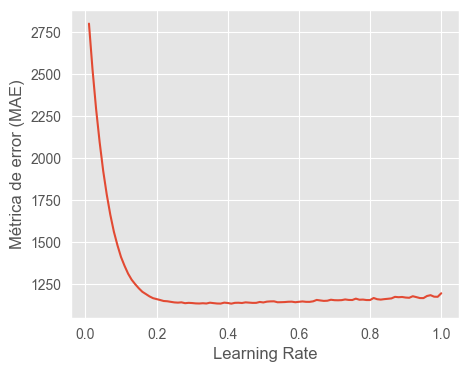

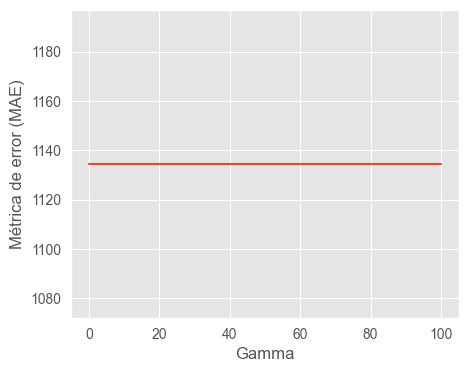

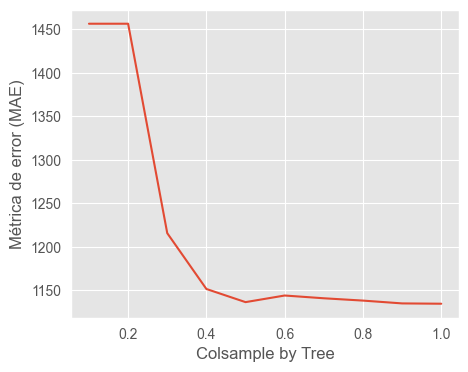

In [30]:
# Celda 7

# Calibración de hiperparámetros: Rata de aprendizaje óptima del algoritmo (learning_rate)
learning_range = [round(x,3) for x in np.linspace(0.01,1,100)]
mae_scores_learn = []

for learn in learning_range:
    xgb_reg_= XGBRegressor(n_estimators=13, max_depth=5,learning_rate=learn,n_jobs=-1)
    xgb_reg_.fit(X_train,y_train)
    y_pred_ = xgb_reg_.predict(X_test)
    mae_scores_learn.append(mean_absolute_error(y_test, y_pred_))

print(f'La rata de aprendizaje óptima es: {learning_range[np.argmin(mae_scores_learn)]} (MAE:{np.min(mae_scores_learn):,.3f}).')

plt.figure(figsize=(5,4))
plt.plot(learning_range, mae_scores_learn)
plt.xlabel('Learning Rate')
plt.ylabel('Métrica de error (MAE)');

# Calibración de hiperparámetros: Valor de gamma óptimo del algoritmo (gamma)

gamma_range = [round(x,2) for x in np.linspace(0,100,50)]
mae_scores_gamma = []

for gamma in gamma_range:
    xgb_reg_= XGBRegressor(n_estimators=13, max_depth=5,learning_rate=learning_range[np.argmin(mae_scores_learn)],gamma=gamma,n_jobs=-1)
    xgb_reg_.fit(X_train,y_train)
    y_pred_ = xgb_reg_.predict(X_test)
    mae_scores_gamma.append(mean_absolute_error(y_test, y_pred_))

print(f'El valor de gamma óptimo es: {gamma_range[np.argmin(mae_scores_gamma)]} (MAE:{np.min(mae_scores_gamma):,.3f}).')

plt.figure(figsize=(5,4))
plt.plot(gamma_range, mae_scores_gamma)
plt.xlabel('Gamma')
plt.ylabel('Métrica de error (MAE)');

# Calibración de hiperparámetros: Número de atributos óptimo por nodo en el árbol (colsample_bytree)

colsample_range = [x for x in np.linspace(0.1,1,10)]
mae_scores_colsample = []

for colsample in colsample_range:
    xgb_reg_= XGBRegressor(n_estimators=13, max_depth=5,learning_rate=learning_range[np.argmin(mae_scores_learn)],gamma=gamma_range[np.argmin(mae_scores_gamma)],colsample_bytree=colsample,n_jobs=-1)
    xgb_reg_.fit(X_train,y_train)
    y_pred_ = xgb_reg_.predict(X_test)
    mae_scores_colsample.append(mean_absolute_error(y_test, y_pred_))

print(f'El número de atributos óptimo por nodo es: {colsample_range[np.argmin(mae_scores_colsample)]} (MAE:{np.min(mae_scores_colsample):,.3f}).')

plt.figure(figsize=(5,4))
plt.plot(colsample_range, mae_scores_colsample)
plt.xlabel('Colsample by Tree')
plt.ylabel('Métrica de error (MAE)');

#Modelo con hiperparámetros calibrados

xgb_reg_opt = XGBRegressor(n_estimators=13, max_depth=5,learning_rate=learning_range[np.argmin(mae_scores_learn)],gamma=gamma_range[np.argmin(mae_scores_gamma)],colsample_bytree=colsample_range[np.argmin(mae_scores_colsample)],n_jobs=-1)
xgb_reg_opt.fit(X_train, y_train)
y_pred_xgb_opt = xgb_reg_opt.predict(X_test)

print(f'Para XGBoost Regressor (calibrado), el MAE es: {mean_absolute_error(y_test, y_pred_xgb_opt):,.3f}, y el RMSE es: {np.sqrt(mean_squared_error(y_test, y_pred_xgb_opt)):,.3f}.')


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [31]:
# Celda 8
